Berner Fachhochschule BFH - MAS Data Science - Graph Machine Learning - Master Thesis FS/2022 Thomas Iten

# Experiment 10 - GraphSAGE Parameter Tests

**Referenzen**<br />
[1] http://snap.stanford.edu/graphsage/<br />
[2] https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/graphsage-link-prediction.html<br />
[3] Stamile, Marzullo, Deusebio. Graph Machine Learning. Packt Publishing 2021. ISBN 978-1-80020-449-2


In [25]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from stellargraph import StellarGraph
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from tensorflow import keras
from sklearn import metrics
from gml.graph.data_factory import TestTrainDataFactory, Direction, GeneralAgency, Employee, DoubleEmployee, DataCollection, MatchingCluster, EdgeLabelFactory
%matplotlib inline

## 10.1 Setup

### Node Features

In [7]:
STANDARD_NODE_FEATURES = {
    "DIR": [1,0,0,0,1,0],
    "GA" : [1,0,0,0,0,1],
    "DC" : [0,1,0,0,1,0],
    "MC" : [0,1,0,0,1,0],
    "EM" : [0,0,1,0,1,0],
    "EMx": [0,0,1,0,0,1],
    "F"  : [0,0,0,1,0,0],
    "L"  : [0,0,0,1,0,0]
}

def eval_feature_matrix_key(node):
    """Evalute and return the feature matrix key for a given node name."""
    if node == Direction.NAME_PREFIX:
        return Direction.NAME_PREFIX
    if node == GeneralAgency.NAME_PREFIX:
        return GeneralAgency.NAME_PREFIX
    if node.startswith(DataCollection.NAME_PREFIX):
        return DataCollection.NAME_PREFIX
    if node.startswith(MatchingCluster.NAME_PREFIX):
        return MatchingCluster.NAME_PREFIX
    if node.startswith(Employee.FIRSTNAME_PREFIX):
        return Employee.FIRSTNAME_PREFIX
    if node.startswith(Employee.LASTNAME_PREFIX):
        return Employee.LASTNAME_PREFIX
    if node.startswith(Employee.ID_PREFIX):
        return Employee.ID_PREFIX
    if node.startswith(Employee.NAME_PREFIX):
        key = Employee.NAME_PREFIX
        if node.endswith(DoubleEmployee.DOUBLE_NAME_POSTFIX):
            key = key + DoubleEmployee.DOUBLE_NAME_POSTFIX
        return key
    raise Exception("Unsupported node nam [{}] detected.".format(node))

def generate_features(graph, feature_matrix):
    """Generate features for all nodes of the graph according the given feature matrix."""
    features = {}
    for i,node in enumerate(graph.nodes):
        key = eval_feature_matrix_key(node)
        features[node] = feature_matrix[key]
    return features

def generate_emx_samples(test_samples, test_labels):
    """Generate employee and employee-x samples to simulate the data constellation of the EDC."""

    # Filter positive edges
    pos_samples = []
    for i in range(len(test_labels)):
        sample = test_samples[i]
        label = test_labels[i]
        if label == 1:
            pos_samples.append(sample)

    # Generate negative samples by appending an x to the employee
    neg_samples = []
    for sample in pos_samples:
        from_node = sample[0]
        to_node = sample[1]
        if from_node.startswith("EM"):
            from_node = from_node + "x"
        if to_node.startswith("EM"):
            to_node = to_node + "x"
        neg_samples.append((from_node, to_node))

    # Generate new test data set
    pos_labels = [1 for _ in range(len(pos_samples))]
    neg_labels = [0 for _ in range(len(neg_samples))]

    # Combine and shuffle samples
    samples = pos_samples
    samples.extend(neg_samples)
    labels = pos_labels
    labels.extend(neg_labels)
    test_samples, test_labels = EdgeLabelFactory().shuffle(samples, labels)

    return test_samples, test_labels


### Test Heat

In [22]:
def heat(name,                                  # The name of the test run
         n=10,                                  # Number of subgraphs with employee - data collection constellation
         feature_matrix=STANDARD_NODE_FEATURES, # Feature Matix to use
         link_gen_batch_size=64,                # Batch Size
         link_gen_num_samples=[4,4],            # List of number of neighbour node samples per GraphSAGE layer (hop) to take.
         model_layer_sizes=[20,20],             # Model layers and size per layer
         model_dropout=0.3,                     # Model dropout in percent
         epochs=12,                             # Number of training epochs
         enable_emx_samples=False):             # Generate EM and EMX Train- and Testdata

    # ---------------------------------------------------------------------------------------------
    # create graph
    # ---------------------------------------------------------------------------------------------

    graph, test_graph, test_samples, test_labels, train_graph, train_samples, train_labels\
        = TestTrainDataFactory().create_testdata(n, add_id=False, add_predict_edges=True)

    graph.print_dimemsions()

    if enable_emx_samples:
        print("Enable EMx test samples")
        test_samples, test_labels = generate_emx_samples(test_samples, test_labels)
        train_samples, train_labels = generate_emx_samples(train_samples, train_labels)

    print("Test samples and labels:")
    print(test_samples[:10], "...")
    print(test_labels[:10], "...")
    print("Train samples and labels:")
    print(train_samples[:10], "...")
    print(train_labels[:10], "...")

    # ---------------------------------------------------------------------------------------------
    # create features
    # ---------------------------------------------------------------------------------------------

    node_features_name = "edc"

    # test graph
    test_features = generate_features(test_graph, feature_matrix)
    nx.set_node_attributes(test_graph.graph, test_features, node_features_name)

    # train graph
    train_features = generate_features(train_graph, feature_matrix)
    nx.set_node_attributes(train_graph.graph, train_features, node_features_name)

    # ---------------------------------------------------------------------------------------------
    # setup link generator
    # ---------------------------------------------------------------------------------------------

    batch_size  = link_gen_batch_size
    num_samples = link_gen_num_samples

    train_sg   = StellarGraph.from_networkx(train_graph.graph, node_features=node_features_name)
    train_gen  = GraphSAGELinkGenerator(train_sg, batch_size, num_samples)
    train_flow = train_gen.flow(train_samples, train_labels, shuffle=True, seed=24)

    test_sg    = StellarGraph.from_networkx(test_graph.graph, node_features=node_features_name)
    test_gen   = GraphSAGELinkGenerator(test_sg, batch_size, num_samples)
    test_flow  = test_gen.flow(test_samples, test_labels, seed=24)

    # ---------------------------------------------------------------------------------------------
    # define GraphSAGE model
    # ---------------------------------------------------------------------------------------------

    layer_sizes = model_layer_sizes
    graphsage = GraphSAGE(
        layer_sizes=layer_sizes,
        generator=train_gen,
        bias=True,
        dropout=model_dropout)

    x_inp, x_out = graphsage.in_out_tensors()
    prediction   = link_classification(output_dim=1, output_act="sigmoid", edge_embedding_method="ip")(x_out)

    model = keras.Model(inputs=x_inp, outputs=prediction)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.mse,
        metrics=["acc"],
    )

    # ---------------------------------------------------------------------------------------------
    # train model
    # ---------------------------------------------------------------------------------------------

    epochs = epochs
    model.fit(train_flow, epochs=epochs, validation_data=test_flow)

    # history = model.fit(train_flow, epochs=epochs, validation_data=test_flow)
    # sg.utils.plot_history(history)

    # ---------------------------------------------------------------------------------------------
    # test performance
    # ---------------------------------------------------------------------------------------------

    def evaluate_metrics(labels, y_pred):
        return {
            "Precision" : "{:.2f}".format(metrics.precision_score(labels, y_pred)),
            "Recall"    : "{:.2f}".format(metrics.recall_score(labels, y_pred)),
            "F1-Score"  : "{:.2f}".format(metrics.f1_score(labels, y_pred))
        }

    y_pred = np.round(model.predict(train_flow)).flatten()
    train_metrics = evaluate_metrics(train_labels, y_pred)

    y_pred = np.round(model.predict(test_flow)).flatten()
    test_metrics = evaluate_metrics(test_labels, y_pred)

    result = {
        "Name"  : name,
        "Train" : train_metrics,
        "Test"  : test_metrics
    }

    return result


def run_heats(tests):
    results = []
    for i, config in enumerate(tests):
        name = "Heat #" + str(i)

        print("---------------------------------------------------------------------------------------------------------")
        print(name)
        print("---------------------------------------------------------------------------------------------------------")

        print("#")
        print("# Test Configuration")
        print("#")
        print(config)

        print("#")
        print("# Train and Tests")
        print("#")
        res = heat(name, **config)
        results.append(res)
    return results

def show_summary(tests, results):
    print("---------------------------------------------------------------------------------------------------------")
    print("Summary")
    print("---------------------------------------------------------------------------------------------------------")

    print("Test Configurations:")
    for test in tests:
        print(test)

    print("\nTest Results:")
    for result in results:
        print(result)

## 10.2 Test GraphSAGE Number of samples

### Train and Test


In [61]:
tests = [

    {"n": 75, "feature_matrix": STANDARD_NODE_FEATURES, "link_gen_batch_size": 64, "link_gen_num_samples": [4,4],
     "model_layer_sizes": [15,15], "model_dropout": 0.1, "epochs": 64},

    {"n": 100, "feature_matrix": STANDARD_NODE_FEATURES, "link_gen_batch_size": 64, "link_gen_num_samples": [4,4],
     "model_layer_sizes": [15,15], "model_dropout": 0.1, "epochs": 64},

    {"n": 200, "feature_matrix": STANDARD_NODE_FEATURES, "link_gen_batch_size": 64, "link_gen_num_samples": [4,4],
     "model_layer_sizes": [15,15], "model_dropout": 0.1, "epochs": 64},

    {"n": 500, "feature_matrix": STANDARD_NODE_FEATURES, "link_gen_batch_size": 64, "link_gen_num_samples": [4,4],
     "model_layer_sizes": [15,15], "model_dropout": 0.1, "epochs": 64},

    {"n": 1000, "feature_matrix": STANDARD_NODE_FEATURES, "link_gen_batch_size": 64, "link_gen_num_samples": [4,4],
     "model_layer_sizes": [15,15], "model_dropout": 0.1, "epochs": 64},
]

results = run_heats(tests)

---------------------------------------------------------------------------------------------------------
Heat #0
---------------------------------------------------------------------------------------------------------
#
# Test Configuration
#
{'n': 75, 'feature_matrix': {'DIR': [1, 0, 0, 0, 1, 0], 'GA': [1, 0, 0, 0, 0, 1], 'DC': [0, 1, 0, 0, 1, 0], 'MC': [0, 1, 0, 0, 1, 0], 'EM': [0, 0, 1, 0, 1, 0], 'EMx': [0, 0, 1, 0, 0, 1], 'F': [0, 0, 0, 1, 0, 0], 'L': [0, 0, 0, 1, 0, 0]}, 'link_gen_batch_size': 64, 'link_gen_num_samples': [4, 4], 'model_layer_sizes': [15, 15], 'model_dropout': 0.1, 'epochs': 64}
#
# Train and Tests
#
Graph dimensions:
  order : 452 (number of nodes)
  size  : 900 (number of edges)
Test samples and labels:
[('DC48', 'EM1'), ('DC5', 'EM9'), ('EM68', 'DC68'), ('DC63', 'EM53'), ('EM23', 'DC72'), ('DC38', 'EM32'), ('EM2', 'DC34'), ('EM10', 'DC26'), ('EM21', 'DC38'), ('EM34', 'DC48')] ...
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0] ...
Train samples and labels:
[('DC11', 'EM11'), (

### Summary

In [62]:
show_summary(tests, results)

---------------------------------------------------------------------------------------------------------
Summary
---------------------------------------------------------------------------------------------------------
Test Configurations:
{'n': 75, 'feature_matrix': {'DIR': [1, 0, 0, 0, 1, 0], 'GA': [1, 0, 0, 0, 0, 1], 'DC': [0, 1, 0, 0, 1, 0], 'MC': [0, 1, 0, 0, 1, 0], 'EM': [0, 0, 1, 0, 1, 0], 'EMx': [0, 0, 1, 0, 0, 1], 'F': [0, 0, 0, 1, 0, 0], 'L': [0, 0, 0, 1, 0, 0]}, 'link_gen_batch_size': 64, 'link_gen_num_samples': [4, 4], 'model_layer_sizes': [15, 15], 'model_dropout': 0.1, 'epochs': 64}
{'n': 100, 'feature_matrix': {'DIR': [1, 0, 0, 0, 1, 0], 'GA': [1, 0, 0, 0, 0, 1], 'DC': [0, 1, 0, 0, 1, 0], 'MC': [0, 1, 0, 0, 1, 0], 'EM': [0, 0, 1, 0, 1, 0], 'EMx': [0, 0, 1, 0, 0, 1], 'F': [0, 0, 0, 1, 0, 0], 'L': [0, 0, 0, 1, 0, 0]}, 'link_gen_batch_size': 64, 'link_gen_num_samples': [4, 4], 'model_layer_sizes': [15, 15], 'model_dropout': 0.1, 'epochs': 64}
{'n': 200, 'feature_matrix': {

### Plot

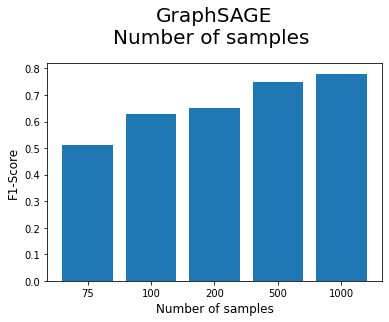

In [63]:
title = "GraphSAGE\nNumber of samples "
xlabel = "Number of samples"
ylabel = "F1-Score"

x = []  # number of samples as x-axis
y = []  # f1 score as y values

for test in tests:
    x.append(str(test['n']))

for result in results:
    y.append(float(result['Test']['F1-Score']))

plt.figure()
plt.title(title, fontsize=20, pad=20)
plt.xlabel(xlabel, fontsize=12)
plt.ylabel(ylabel, fontsize=12)
plt.bar(x,y)
plt.show()

## 10.3 Test GraphSAGE Layer sizes

### Train and Test

In [64]:
tests = [
    {"n": 500, "feature_matrix": STANDARD_NODE_FEATURES, "link_gen_batch_size": 64, "link_gen_num_samples": [4,4],
     "model_layer_sizes": [10,10], "model_dropout": 0.1, "epochs": 64},

    {"n": 500, "feature_matrix": STANDARD_NODE_FEATURES, "link_gen_batch_size": 64, "link_gen_num_samples": [4,4],
     "model_layer_sizes": [15,15], "model_dropout": 0.1, "epochs": 64},

    {"n": 500, "feature_matrix": STANDARD_NODE_FEATURES, "link_gen_batch_size": 64, "link_gen_num_samples": [4,4],
     "model_layer_sizes": [20,20], "model_dropout": 0.1, "epochs": 64},

    {"n": 500, "feature_matrix": STANDARD_NODE_FEATURES, "link_gen_batch_size": 64, "link_gen_num_samples": [4,4],
     "model_layer_sizes": [25,25], "model_dropout": 0.1, "epochs": 64},

    {"n": 500, "feature_matrix": STANDARD_NODE_FEATURES, "link_gen_batch_size": 64, "link_gen_num_samples": [4,4],
     "model_layer_sizes": [30,30], "model_dropout": 0.1, "epochs": 64},

    {"n": 500, "feature_matrix": STANDARD_NODE_FEATURES, "link_gen_batch_size": 64, "link_gen_num_samples": [4,4],
     "model_layer_sizes": [40,40], "model_dropout": 0.1, "epochs": 64},
]

results = run_heats(tests)

---------------------------------------------------------------------------------------------------------
Heat #0
---------------------------------------------------------------------------------------------------------
#
# Test Configuration
#
{'n': 500, 'feature_matrix': {'DIR': [1, 0, 0, 0, 1, 0], 'GA': [1, 0, 0, 0, 0, 1], 'DC': [0, 1, 0, 0, 1, 0], 'MC': [0, 1, 0, 0, 1, 0], 'EM': [0, 0, 1, 0, 1, 0], 'EMx': [0, 0, 1, 0, 0, 1], 'F': [0, 0, 0, 1, 0, 0], 'L': [0, 0, 0, 1, 0, 0]}, 'link_gen_batch_size': 64, 'link_gen_num_samples': [4, 4], 'model_layer_sizes': [10, 10], 'model_dropout': 0.1, 'epochs': 64}
#
# Train and Tests
#
Graph dimensions:
  order : 3002 (number of nodes)
  size  : 6000 (number of edges)
Test samples and labels:
[('EM51', 'DC93'), ('EM326', 'DC261'), ('EM129', 'DC42'), ('EM85', 'DC234'), ('DC455', 'EM455'), ('DC149', 'EM241'), ('EM70', 'DC70'), ('DC41', 'EM41'), ('DC158', 'EM24'), ('DC321', 'EM210')] ...
[0, 0, 0, 0, 1, 0, 1, 1, 0, 0] ...
Train samples and labels:
[(

### Summary

In [65]:
show_summary(tests, results)

---------------------------------------------------------------------------------------------------------
Summary
---------------------------------------------------------------------------------------------------------
Test Configurations:
{'n': 500, 'feature_matrix': {'DIR': [1, 0, 0, 0, 1, 0], 'GA': [1, 0, 0, 0, 0, 1], 'DC': [0, 1, 0, 0, 1, 0], 'MC': [0, 1, 0, 0, 1, 0], 'EM': [0, 0, 1, 0, 1, 0], 'EMx': [0, 0, 1, 0, 0, 1], 'F': [0, 0, 0, 1, 0, 0], 'L': [0, 0, 0, 1, 0, 0]}, 'link_gen_batch_size': 64, 'link_gen_num_samples': [4, 4], 'model_layer_sizes': [10, 10], 'model_dropout': 0.1, 'epochs': 64}
{'n': 500, 'feature_matrix': {'DIR': [1, 0, 0, 0, 1, 0], 'GA': [1, 0, 0, 0, 0, 1], 'DC': [0, 1, 0, 0, 1, 0], 'MC': [0, 1, 0, 0, 1, 0], 'EM': [0, 0, 1, 0, 1, 0], 'EMx': [0, 0, 1, 0, 0, 1], 'F': [0, 0, 0, 1, 0, 0], 'L': [0, 0, 0, 1, 0, 0]}, 'link_gen_batch_size': 64, 'link_gen_num_samples': [4, 4], 'model_layer_sizes': [15, 15], 'model_dropout': 0.1, 'epochs': 64}
{'n': 500, 'feature_matrix': 

### Plot

0.69 <class 'float'>
0.75 <class 'float'>
0.7 <class 'float'>
0.77 <class 'float'>
0.79 <class 'float'>
0.77 <class 'float'>


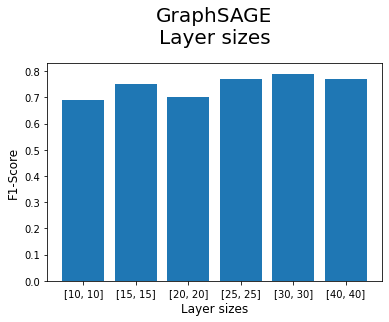

In [66]:
title = "GraphSAGE\nLayer sizes"
xlabel = "Layer sizes"
ylabel = "F1-Score"

x = []  # number of samples as x-axis
y = []  # f1 score as y values

for test in tests:
    x.append(str(test['model_layer_sizes']))

for result in results:
    y.append(float(result['Test']['F1-Score']))

plt.figure()
plt.title(title, fontsize=20, pad=20)
plt.xlabel(xlabel, fontsize=12)
plt.ylabel(ylabel, fontsize=12)
plt.bar(x,y)
plt.show()

## 10.4 Test GraphSAGE Hop sizes

### Train and Test

In [74]:
tests = [
    {"n": 500, "feature_matrix": STANDARD_NODE_FEATURES, "link_gen_batch_size": 64, "link_gen_num_samples": [1,1],
     "model_layer_sizes": [15,15], "model_dropout": 0.1, "epochs": 64},

    {"n": 500, "feature_matrix": STANDARD_NODE_FEATURES, "link_gen_batch_size": 64, "link_gen_num_samples": [2,2],
     "model_layer_sizes": [15,15], "model_dropout": 0.1, "epochs": 64},

    {"n": 500, "feature_matrix": STANDARD_NODE_FEATURES, "link_gen_batch_size": 64, "link_gen_num_samples": [3,3],
     "model_layer_sizes": [15,15], "model_dropout": 0.1, "epochs": 64},

    {"n": 500, "feature_matrix": STANDARD_NODE_FEATURES, "link_gen_batch_size": 64, "link_gen_num_samples": [5,5],
     "model_layer_sizes": [15,15], "model_dropout": 0.1, "epochs": 64},

    {"n": 500, "feature_matrix": STANDARD_NODE_FEATURES, "link_gen_batch_size": 64, "link_gen_num_samples": [8,8],
     "model_layer_sizes": [15,15], "model_dropout": 0.1, "epochs": 64},

    {"n": 500, "feature_matrix": STANDARD_NODE_FEATURES, "link_gen_batch_size": 64, "link_gen_num_samples": [12,12],
     "model_layer_sizes": [15,15], "model_dropout": 0.1, "epochs": 64},
]

results = run_heats(tests)

---------------------------------------------------------------------------------------------------------
Heat #0
---------------------------------------------------------------------------------------------------------
#
# Test Configuration
#
{'n': 500, 'feature_matrix': {'DIR': [1, 0, 0, 0, 1, 0], 'GA': [1, 0, 0, 0, 0, 1], 'DC': [0, 1, 0, 0, 1, 0], 'MC': [0, 1, 0, 0, 1, 0], 'EM': [0, 0, 1, 0, 1, 0], 'EMx': [0, 0, 1, 0, 0, 1], 'F': [0, 0, 0, 1, 0, 0], 'L': [0, 0, 0, 1, 0, 0]}, 'link_gen_batch_size': 64, 'link_gen_num_samples': [1, 1], 'model_layer_sizes': [15, 15], 'model_dropout': 0.1, 'epochs': 64}
#
# Train and Tests
#
Graph dimensions:
  order : 3002 (number of nodes)
  size  : 6000 (number of edges)
Test samples and labels:
[('DC201', 'EM201'), ('DC293', 'EM293'), ('EM390', 'DC390'), ('DC217', 'EM38'), ('EM412', 'DC412'), ('DC398', 'EM216'), ('DC485', 'EM485'), ('EM332', 'DC155'), ('DC339', 'EM274'), ('EM56', 'DC56')] ...
[1, 1, 1, 0, 1, 0, 1, 0, 0, 1] ...
Train samples and labe

### Summary

In [75]:
show_summary(tests, results)

---------------------------------------------------------------------------------------------------------
Summary
---------------------------------------------------------------------------------------------------------
Test Configurations:
{'n': 500, 'feature_matrix': {'DIR': [1, 0, 0, 0, 1, 0], 'GA': [1, 0, 0, 0, 0, 1], 'DC': [0, 1, 0, 0, 1, 0], 'MC': [0, 1, 0, 0, 1, 0], 'EM': [0, 0, 1, 0, 1, 0], 'EMx': [0, 0, 1, 0, 0, 1], 'F': [0, 0, 0, 1, 0, 0], 'L': [0, 0, 0, 1, 0, 0]}, 'link_gen_batch_size': 64, 'link_gen_num_samples': [1, 1], 'model_layer_sizes': [15, 15], 'model_dropout': 0.1, 'epochs': 64}
{'n': 500, 'feature_matrix': {'DIR': [1, 0, 0, 0, 1, 0], 'GA': [1, 0, 0, 0, 0, 1], 'DC': [0, 1, 0, 0, 1, 0], 'MC': [0, 1, 0, 0, 1, 0], 'EM': [0, 0, 1, 0, 1, 0], 'EMx': [0, 0, 1, 0, 0, 1], 'F': [0, 0, 0, 1, 0, 0], 'L': [0, 0, 0, 1, 0, 0]}, 'link_gen_batch_size': 64, 'link_gen_num_samples': [2, 2], 'model_layer_sizes': [15, 15], 'model_dropout': 0.1, 'epochs': 64}
{'n': 500, 'feature_matrix': 

### Plot

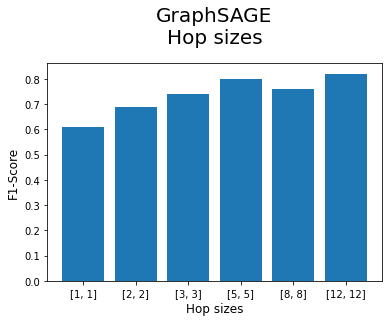

In [76]:
title = "GraphSAGE\nHop sizes"
xlabel = "Hop sizes"
ylabel = "F1-Score"

x = []  # number of samples as x-axis
y = []  # f1 score as y values

for test in tests:
    x.append(str(test['link_gen_num_samples']))

for result in results:
    y.append(float(result['Test']['F1-Score']))

plt.figure()
plt.title(title, fontsize=20, pad=20)
plt.xlabel(xlabel, fontsize=12)
plt.ylabel(ylabel, fontsize=12)
plt.bar(x,y)
plt.show()

## 10.5 Test GraphSAGE Number of epochs

### Train and Test


In [80]:
tests = [
    {"n": 500, "feature_matrix": STANDARD_NODE_FEATURES, "link_gen_batch_size": 64, "link_gen_num_samples": [5,5],
     "model_layer_sizes": [15,15], "model_dropout": 0.1, "epochs": 32},

    {"n": 500, "feature_matrix": STANDARD_NODE_FEATURES, "link_gen_batch_size": 64, "link_gen_num_samples": [5,5],
     "model_layer_sizes": [15,15], "model_dropout": 0.1, "epochs": 64},

    {"n": 500, "feature_matrix": STANDARD_NODE_FEATURES, "link_gen_batch_size": 64, "link_gen_num_samples": [5,5],
     "model_layer_sizes": [15,15], "model_dropout": 0.1, "epochs": 128},

    {"n": 500, "feature_matrix": STANDARD_NODE_FEATURES, "link_gen_batch_size": 64, "link_gen_num_samples": [5,5],
     "model_layer_sizes": [15,15], "model_dropout": 0.1, "epochs": 256},

    {"n": 500, "feature_matrix": STANDARD_NODE_FEATURES, "link_gen_batch_size": 64, "link_gen_num_samples": [5,5],
     "model_layer_sizes": [15,15], "model_dropout": 0.1, "epochs": 512},

    {"n": 500, "feature_matrix": STANDARD_NODE_FEATURES, "link_gen_batch_size": 64, "link_gen_num_samples": [5,5],
     "model_layer_sizes": [15,15], "model_dropout": 0.1, "epochs": 1024},
]

results = run_heats(tests)

---------------------------------------------------------------------------------------------------------
Heat #0
---------------------------------------------------------------------------------------------------------
#
# Test Configuration
#
{'n': 500, 'feature_matrix': {'DIR': [1, 0, 0, 0, 1, 0], 'GA': [1, 0, 0, 0, 0, 1], 'DC': [0, 1, 0, 0, 1, 0], 'MC': [0, 1, 0, 0, 1, 0], 'EM': [0, 0, 1, 0, 1, 0], 'EMx': [0, 0, 1, 0, 0, 1], 'F': [0, 0, 0, 1, 0, 0], 'L': [0, 0, 0, 1, 0, 0]}, 'link_gen_batch_size': 64, 'link_gen_num_samples': [5, 5], 'model_layer_sizes': [15, 15], 'model_dropout': 0.1, 'epochs': 32}
#
# Train and Tests
#
Graph dimensions:
  order : 3002 (number of nodes)
  size  : 6000 (number of edges)
Test samples and labels:
[('DC271', 'EM181'), ('EM118', 'DC118'), ('DC309', 'EM309'), ('EM335', 'DC313'), ('DC346', 'EM256'), ('EM314', 'DC491'), ('DC450', 'EM146'), ('EM54', 'DC80'), ('EM430', 'DC181'), ('EM163', 'DC7')] ...
[0, 1, 1, 0, 0, 0, 0, 0, 0, 0] ...
Train samples and label

### Summary

In [81]:
show_summary(tests, results)

---------------------------------------------------------------------------------------------------------
Summary
---------------------------------------------------------------------------------------------------------
Test Configurations:
{'n': 500, 'feature_matrix': {'DIR': [1, 0, 0, 0, 1, 0], 'GA': [1, 0, 0, 0, 0, 1], 'DC': [0, 1, 0, 0, 1, 0], 'MC': [0, 1, 0, 0, 1, 0], 'EM': [0, 0, 1, 0, 1, 0], 'EMx': [0, 0, 1, 0, 0, 1], 'F': [0, 0, 0, 1, 0, 0], 'L': [0, 0, 0, 1, 0, 0]}, 'link_gen_batch_size': 64, 'link_gen_num_samples': [5, 5], 'model_layer_sizes': [15, 15], 'model_dropout': 0.1, 'epochs': 32}
{'n': 500, 'feature_matrix': {'DIR': [1, 0, 0, 0, 1, 0], 'GA': [1, 0, 0, 0, 0, 1], 'DC': [0, 1, 0, 0, 1, 0], 'MC': [0, 1, 0, 0, 1, 0], 'EM': [0, 0, 1, 0, 1, 0], 'EMx': [0, 0, 1, 0, 0, 1], 'F': [0, 0, 0, 1, 0, 0], 'L': [0, 0, 0, 1, 0, 0]}, 'link_gen_batch_size': 64, 'link_gen_num_samples': [5, 5], 'model_layer_sizes': [15, 15], 'model_dropout': 0.1, 'epochs': 64}
{'n': 500, 'feature_matrix': 

### Plot

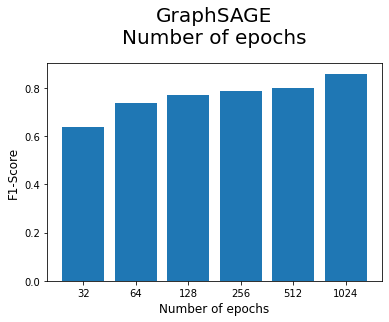

In [82]:
title = "GraphSAGE\nNumber of epochs"
xlabel = "Number of epochs"
ylabel = "F1-Score"

x = []  # number of samples as x-axis
y = []  # f1 score as y values

for test in tests:
    x.append(str(test['epochs']))

for result in results:
    y.append(float(result['Test']['F1-Score']))

plt.figure()
plt.title(title, fontsize=20, pad=20)
plt.xlabel(xlabel, fontsize=12)
plt.ylabel(ylabel, fontsize=12)
plt.bar(x,y)
plt.show()


---
_The end._